# Load enviornment and dependanceies

## RUN THESE COMMANDS IN THE TERMINAL THE FIRST TIME YOU OPEN THID NOTEBOOK!
This installs the required venv to the system so you can use it in jupyter
```bash
source .venv/bin/activate
python -m ipykernel install --user --name=venv
```
Then select the kernel selction in the top right (it should say someting like Python ...) and choose "venv"


In [3]:
import torch
from transformers import AutoModelForCausalLM
from Janus.janus.models import MultiModalityCausalLM, VLChatProcessor
from Janus.janus.utils.io import load_pil_images

# specify the path to the model
# model_path = "/projectnb/cs598/projects/cool_proj/model"
project_path = "/Users/nover/repos/class/CASCS 598 MML/Project/"
model_path = project_path + "model"

if torch.cuda.is_available():
    device = 'cuda'
elif torch.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

vl_chat_processor: VLChatProcessor = VLChatProcessor.from_pretrained(model_path, use_fast=True)
tokenizer = vl_chat_processor.tokenizer

vl_gpt: MultiModalityCausalLM = AutoModelForCausalLM.from_pretrained(
    model_path, trust_remote_code=True
)

vl_gpt = vl_gpt.to(torch.bfloat16).to(device).eval()



Some kwargs in processor config are unused and will not have any effect: sft_format, ignore_id, image_tag, add_special_token, mask_prompt, num_image_tokens. 


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

# Image & Text to Text

In [3]:
conversation = [
    {
        "role": "<|User|>",
        "content": f"<image_placeholder>\nWhat is the historical context of this world famous image?",
        "images": [project_path + 'img.jpg'],
    },
    {"role": "<|Assistant|>", "content": ""},
]

# load images and prepare for inputs
pil_images = load_pil_images(conversation)
prepare_inputs = vl_chat_processor(
    conversations=conversation, images=pil_images, force_batchify=True
).to(vl_gpt.device)

# # run image encoder to get the image embeddings
inputs_embeds = vl_gpt.prepare_inputs_embeds(**prepare_inputs)

# # run the model to get the response
outputs = vl_gpt.language_model.generate(
    inputs_embeds=inputs_embeds,
    attention_mask=prepare_inputs.attention_mask,
    pad_token_id=tokenizer.eos_token_id,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
    max_new_tokens=512,
    do_sample=False,
    use_cache=True,
)

answer = tokenizer.decode(outputs[0].cpu().tolist(), skip_special_tokens=True)
print(f"{prepare_inputs['sft_format'][0]}", answer)



You are a helpful language and vision assistant. You are able to understand the visual content that the user provides, and assist the user with a variety of tasks using natural language.

<|User|>: <image_placeholder>
What is the historical context of this world famous image?

<|Assistant|>: This image is a famous photograph taken by Associated Press photographer Nick Ut on April 30, 1975. The photograph shows a group of South Vietnamese soldiers marching down a street in Saigon (now Ho Chi Minh City) as they retreat from the city during the Vietnam War. The soldiers are seen marching away from a burning school building, which is visible in the background. The image is a powerful representation of the chaos and destruction of the war, and it has become one of the most iconic images of the Vietnam War.


# Text to Image

In [1]:

import numpy as np
import PIL
import os

conversation = [
    {
        "role": "<|User|>",
        "content": "tiananmen square",
    },
    {"role": "<|Assistant|>", "content": ""},
]

sft_format = vl_chat_processor.apply_sft_template_for_multi_turn_prompts(
    conversations=conversation,
    sft_format=vl_chat_processor.sft_format,
    system_prompt="",
)

prompt = sft_format + vl_chat_processor.image_start_tag

@torch.inference_mode()
def generate(
    mmgpt: MultiModalityCausalLM,
    vl_chat_processor: VLChatProcessor,
    prompt: str,
    temperature: float = 1,
    parallel_size: int = 4,
    cfg_weight: float = 5,
    image_token_num_per_image: int = 576,
    img_size: int = 384,
    patch_size: int = 16,
    num_channels: int = 8,
):
    input_ids = vl_chat_processor.tokenizer.encode(prompt)
    input_ids = torch.LongTensor(input_ids)

    tokens = torch.zeros((parallel_size*2, len(input_ids)), dtype=torch.int).to(device)

    for i in range(parallel_size*2):
        tokens[i, :] = input_ids
        if i % 2 != 0:
            tokens[i, 1:-1] = vl_chat_processor.pad_id

    inputs_embeds = mmgpt.language_model.get_input_embeddings()(tokens)

    generated_tokens = torch.zeros((parallel_size, image_token_num_per_image), dtype=torch.int).to(device)

    for i in range(image_token_num_per_image):
        outputs = mmgpt.language_model.model(inputs_embeds=inputs_embeds, use_cache=True, past_key_values=outputs.past_key_values if i != 0 else None)
        hidden_states = outputs.last_hidden_state
        
        logits = mmgpt.gen_head(hidden_states[:, -1, :])
        logit_cond = logits[0::2, :]
        logit_uncond = logits[1::2, :]
        
        logits = logit_uncond + cfg_weight * (logit_cond-logit_uncond)
        probs = torch.softmax(logits / temperature, dim=-1)

        next_token = torch.multinomial(probs, num_samples=1)
        generated_tokens[:, i] = next_token.squeeze(dim=-1)

        next_token = torch.cat([next_token.unsqueeze(dim=1), next_token.unsqueeze(dim=1)], dim=1).view(-1)
        img_embeds = mmgpt.prepare_gen_img_embeds(next_token)
        inputs_embeds = img_embeds.unsqueeze(dim=1)


    dec = mmgpt.gen_vision_model.decode_code(generated_tokens.to(dtype=torch.int), shape=[parallel_size, num_channels, img_size//patch_size, img_size//patch_size])
    dec = dec.to(torch.float32).cpu().numpy().transpose(0, 2, 3, 1)

    dec = np.clip((dec + 1) / 2 * 255, 0, 255)

    visual_img = np.zeros((parallel_size, img_size, img_size, 3), dtype=np.uint8)
    visual_img[:, :, :] = dec

    os.makedirs('generated_samples', exist_ok=True)
    for i in range(parallel_size):
        save_path = os.path.join(project_path, 'generated_samples', "img_{}.jpg".format(i))
        PIL.Image.fromarray(visual_img[i]).save(save_path)

generate(
    vl_gpt,
    vl_chat_processor,
    prompt,
    parallel_size=1
    ,
    img_size=384//1,
    patch_size=16//1,
    image_token_num_per_image=576//1,
    num_channels=8//1,
)

NameError: name 'vl_chat_processor' is not defined

In [7]:
import torch
from transformers import AutoModelForCausalLM
from Janus.janus.models import MultiModalityCausalLM, VLChatProcessor
from Janus.janus.utils.io import load_pil_images
import numpy as np
import PIL
import os

# specify the path to the model
project_path = "/Users/nover/repos/class/CASCS 598 MML/Project/"
model_path = project_path + "model"

if torch.cuda.is_available():
    device = 'cuda'
elif torch.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

vl_chat_processor: VLChatProcessor = VLChatProcessor.from_pretrained(model_path, use_fast=True)
tokenizer = vl_chat_processor.tokenizer

vl_gpt: MultiModalityCausalLM = AutoModelForCausalLM.from_pretrained(
    model_path, trust_remote_code=True
)

vl_gpt = vl_gpt.to(torch.bfloat16).to(device).eval()

# Image & Text to Text
conversation = [
    {
        "role": "<|User|>",
        "content": f"<image_placeholder>\nWhat is the historical context of this world famous image?",
        "images": [project_path + 'img.jpg'],
    },
    {"role": "<|Assistant|>", "content": ""},
]

pil_images = load_pil_images(conversation)
prepare_inputs = vl_chat_processor(
    conversations=conversation, images=pil_images, force_batchify=True
).to(vl_gpt.device)

inputs_embeds = vl_gpt.prepare_inputs_embeds(**prepare_inputs)

outputs = vl_gpt.language_model.generate(
    inputs_embeds=inputs_embeds,
    attention_mask=prepare_inputs.attention_mask,
    pad_token_id=tokenizer.eos_token_id,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
    max_new_tokens=512,
    do_sample=False,
    use_cache=True,
)

answer = tokenizer.decode(outputs[0].cpu().tolist(), skip_special_tokens=True)
print(f"{prepare_inputs['sft_format'][0]}", answer)

# Text to Image
conversation = [
    {
        "role": "<|User|>",
        "content": "tiananmen square",
    },
    {"role": "<|Assistant|>", "content": ""},
]

sft_format = vl_chat_processor.apply_sft_template_for_multi_turn_prompts(
    conversations=conversation,
    sft_format=vl_chat_processor.sft_format,
    system_prompt="",
)

prompt = sft_format + vl_chat_processor.image_start_tag


@torch.inference_mode()
def generate(
        mmgpt: MultiModalityCausalLM,
        vl_chat_processor: VLChatProcessor,
        prompt: str,
        temperature: float = 1,
        parallel_size: int = 4,
        cfg_weight: float = 5,
        image_token_num_per_image: int = 576,
        img_size: int = 384,
        patch_size: int = 16,
        num_channels: int = 8,
):
    input_ids = vl_chat_processor.tokenizer.encode(prompt)
    input_ids = torch.LongTensor(input_ids)

    tokens = torch.zeros((parallel_size * 2, len(input_ids)), dtype=torch.int).to(device)

    for i in range(parallel_size * 2):
        tokens[i, :] = input_ids
        if i % 2 != 0:
            tokens[i, 1:-1] = vl_chat_processor.pad_id

    inputs_embeds = mmgpt.language_model.get_input_embeddings()(tokens)

    generated_tokens = torch.zeros((parallel_size, image_token_num_per_image), dtype=torch.int).to(device)

    outputs = None
    for i in range(image_token_num_per_image):
        outputs = mmgpt.language_model.model(
            inputs_embeds=inputs_embeds,
            use_cache=True,
            past_key_values=outputs.past_key_values if i != 0 else None
        )
        hidden_states = outputs.last_hidden_state

        logits = mmgpt.gen_head(hidden_states[:, -1, :])
        logit_cond = logits[0::2, :]
        logit_uncond = logits[1::2, :]

        logits = logit_uncond + cfg_weight * (logit_cond - logit_uncond)
        probs = torch.softmax(logits / temperature, dim=-1)

        next_token = torch.multinomial(probs, num_samples=1)
        generated_tokens[:, i] = next_token.squeeze(dim=-1)

        next_token = torch.cat([next_token.unsqueeze(dim=1), next_token.unsqueeze(dim=1)], dim=1).view(-1)
        img_embeds = mmgpt.prepare_gen_img_embeds(next_token)
        inputs_embeds = img_embeds.unsqueeze(dim=1)

    dec = mmgpt.gen_vision_model.decode_code(
        generated_tokens.to(dtype=torch.int),
        shape=[parallel_size, num_channels, img_size // patch_size, img_size // patch_size]
    )
    dec = dec.to(torch.float32).cpu().numpy().transpose(0, 2, 3, 1)
    dec = np.clip((dec + 1) / 2 * 255, 0, 255)

    visual_img = np.zeros((parallel_size, img_size, img_size, 3), dtype=np.uint8)
    visual_img[:, :, :] = dec

    os.makedirs('generated_samples', exist_ok=True)
    for i in range(parallel_size):
        save_path = os.path.join(project_path, 'generated_samples', f"img_{i}.jpg")
        PIL.Image.fromarray(visual_img[i]).save(save_path)


generate(
    vl_gpt,
    vl_chat_processor,
    prompt,
    parallel_size=1,  # small parallel size
    img_size=384 // 2,  # reduce dimension
    patch_size=16 // 2,  # reduce patch size
    image_token_num_per_image=576 // 2,  # reduce total tokens
    num_channels=8  # keep channels at 8 to match model
)

Some kwargs in processor config are unused and will not have any effect: sft_format, add_special_token, image_tag, ignore_id, num_image_tokens, mask_prompt. 


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

KeyboardInterrupt: 

dict_keys(['train', 'validation'])
dict_keys(['image_bytes', 'question', 'answers', 'question_type', 'correct_answer'])


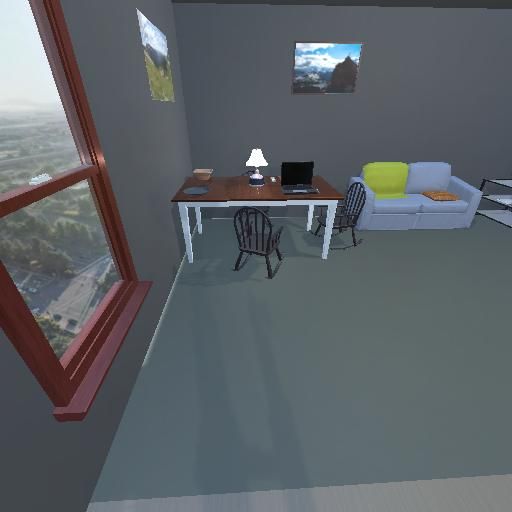

How many Chairs are visible in the scene?
['3', '0', '6', '4', '5']
3


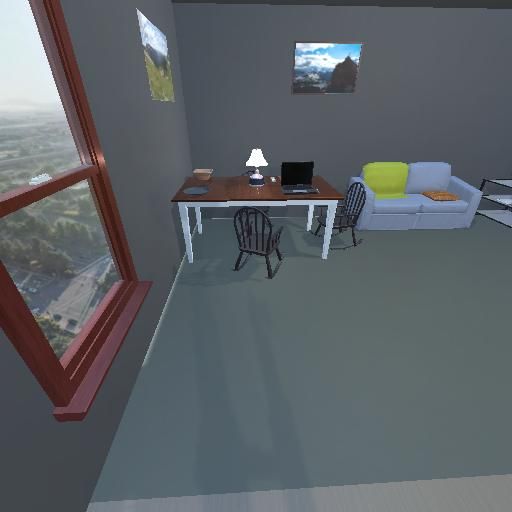

How many DiningTables are visible in the scene?
['1', '0', '6', '4', '5']
1


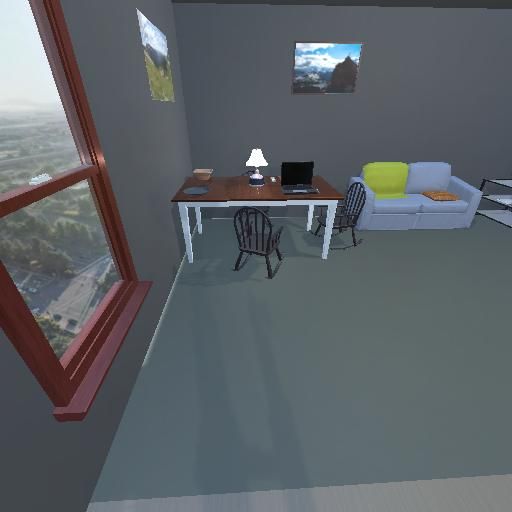

How many Sofas are visible in the scene?
['1', '0', '6', '4', '5']
1


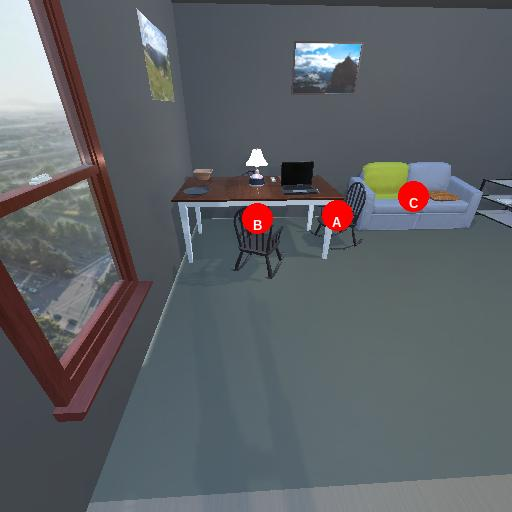

Which point is closer to the camera taking this photo, point A  or point B?
['B', 'A']
B


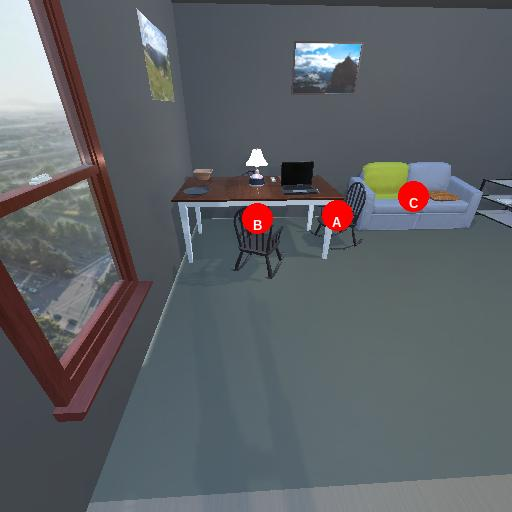

Is black colour chair (marked A) behind brown top white leg dining table (marked B)?
['yes', 'no']
yes


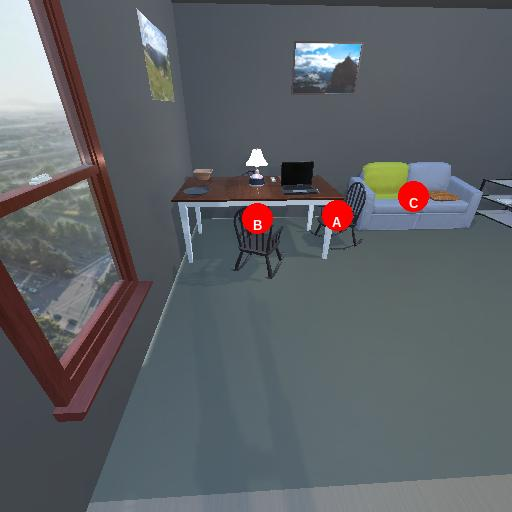

Which point is closer to the camera taking this photo, point B  or point C?
['B', 'C']
B


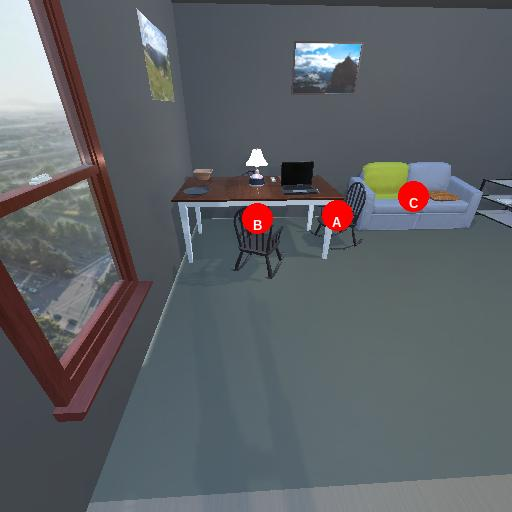

Considering the relative positions, where is black colour chair (marked A) with respect to brown top white leg dining table (marked B)?
['right', 'left']
right


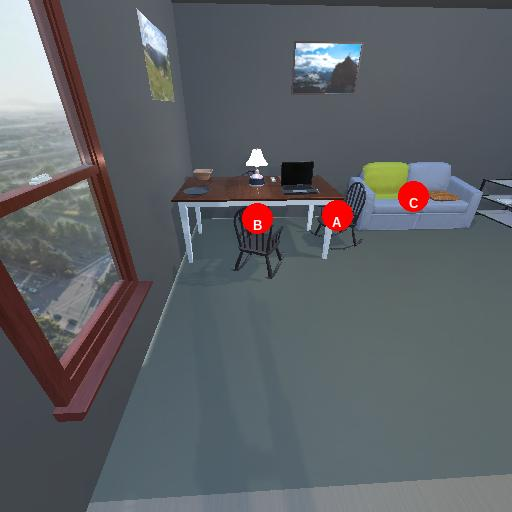

Considering the relative positions, where is brown top white leg dining table (marked B) with respect to blue two-seater sofa with green and blue cushions (marked C)?
['left', 'right']
left


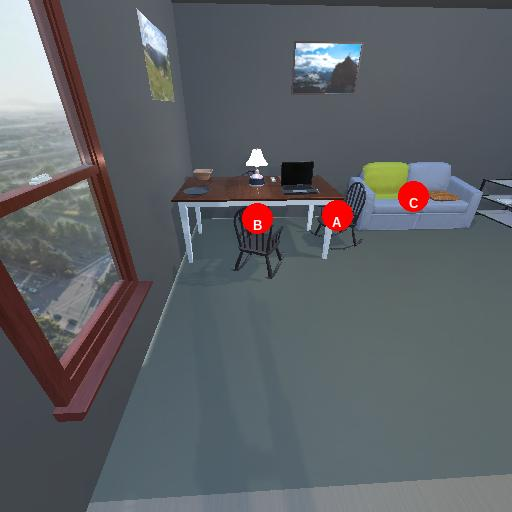

Considering the relative positions, is black colour chair (marked A) to the left or right of blue two-seater sofa with green and blue cushions (marked C)?
['left', 'right']
left


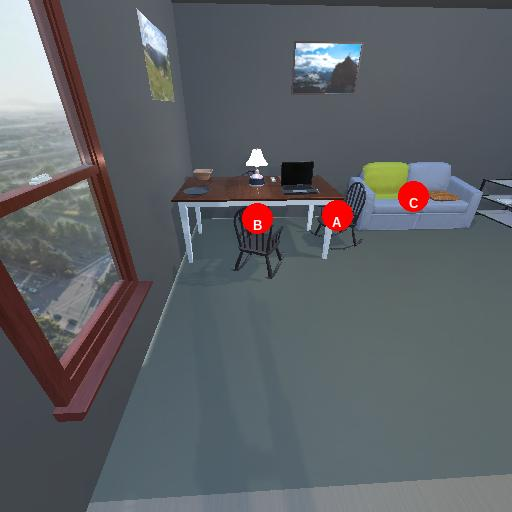

Considering the relative positions, is brown top white leg dining table (marked B) above or below black colour chair (marked A)?
['below', 'above']
below


In [25]:

from datasets import load_dataset
import io

dataset = load_dataset("array/SAT", batch_size=128)

# dataset should have a training and validation key
print(dataset.keys())
example = dataset['train'][:10] # example 10th item
print(example.keys())
for i in range(len(example['image_bytes'])):
    display(example['image_bytes'][i][0])
    print(example['question'][i])
    print(example['answers'][i])
    print(example['correct_answer'][i])



In [ ]:
import io
from PIL import Image

# Example dataset structure
dataset = {
    'validation': [
        {
            'image_bytes': [b'some_raw_bytes', b'some_other_raw_bytes'],
            'question': 'Sample question 1',
            'answers': ['Answer A', 'Answer B']
        },
        {
            'image_bytes': [Image.new('RGB', (100, 100)), Image.new('RGB', (200, 200))],
            'question': 'Sample question 2',
            'answers': ['Answer C', 'Answer D']
        }
        # ...
    ]
}

example = dataset['validation'][1]  # 10 in your original code, changed here for illustration

images = []
for item in example['image_bytes']:
    if isinstance(item, bytes):
        images.append(Image.open(io.BytesIO(item)))
    else:
        # If already a PIL image, keep as is
        images.append(item)

question = example['question']
answer_choices = example['answers']
print(f"Number of images: {len(images)}")
print(f"Question: {question}")
print(f"Answer Choices: {answer_choices}")